# Second stage CEF Fit to $\rm K Er Se_2$

This time, we fit everything we can think of: background, thermal expansion, you name it.
We also include the results from $\rm CsErSe_2$ fits to compare to the fit from KES_CEF_fitPC.ipynb.

Allen Scheie

November 2019

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
import sys

cpal1 = plt.cm.Set1(np.arange(9))
import PyCrystalField as cef

In [2]:
data1p6K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_1p6K.txt', unpack=True)
data15K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_15K.txt', unpack=True)
data100K = np.genfromtxt('KES_CEF_data/cuts_ei9mev_100K.txt', unpack=True)

alldata = [data1p6K,data15K,data100K]
datatemps = [1.8, 15, 100]

<IPython.core.display.Javascript object>


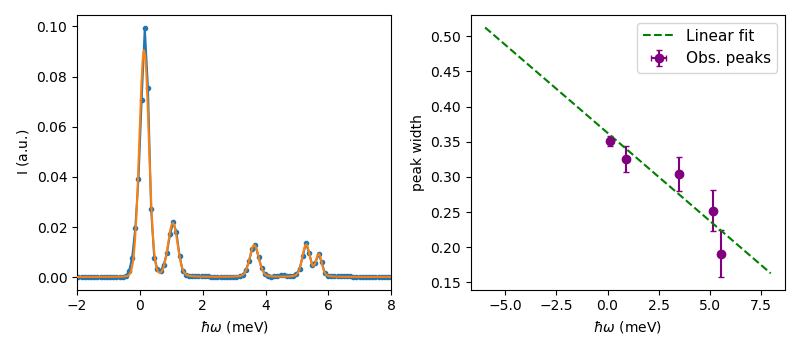

[0.13515156487106053, 0.9132071732842264, 3.504800645878369, 5.155917342976868, 5.560145541287389] [0.3512410705480638, 0.3253514112153624, 0.3043522834245795, 0.25200588513890115, 0.1910902208311937] 0.061315245063475
[-0.0249575   0.36262711]


In [3]:
## Pick out observed eigenvalues
from scipy.special import wofz


def gaus(x, a, x0, sig):
    return a/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - x0)/sig, 2.)/2.)

def voigt(x, a, x0, alpha, gamma):
    """ Return the Voigt line shape at x with Lorentzian component FWHM gamma
    and Gaussian component FWHM alpha."""
    sigma = (0.5*alpha) / np.sqrt(2 * np.log(2))
    return a*np.real(wofz(((x-x0) + 1j*(0.5*gamma))/sigma/np.sqrt(2))) / sigma\
                                                        /np.sqrt(2*np.pi)

dx, dy, de = alldata[0][0], alldata[0][1], alldata[0][2]

def gausfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4):
    return gaus(x-x0, a0,0,w0) + gaus(x-x0, a1,x1,w1) + gaus(x-x0, a2,x2,w2) +\
            gaus(x-x0, a3,x3,w3) + gaus(x-x0, a4,x4,w4) + 0.00015

LW = 0.1
def voigtfitfun(x, a0,x0,w0, a1,x1,w1, a2,x2,w2, a3,x3,w3, a4,x4,w4, lw0, lw):
    return voigt(x-x0, a0,0,w0, lw0) + voigt(x-x0, a1,x1,w1, lw) + voigt(x-x0, a2,x2,w2, lw) +\
            voigt(x-x0, a3,x3,w3, lw) + voigt(x-x0, a4,x4,w4, lw) + 0.00015

p0 = [4e-2, 0.15,0.25, 9e-3,0.87,0.25, 5e-3,3.47,0.25, 5e-3,5.11,0.18, 4e-3,5.58,0.18, 0.1, 0.1]

poptinitial, pcovinitial = curve_fit(voigtfitfun, dx, dy, sigma=de, p0=p0)
uncinitial = np.sqrt(np.diag(pcovinitial))

f, ax = plt.subplots(1,2, figsize=(8,3.5))

ax[0].errorbar(dx,dy,de, marker='.')
xxx = np.linspace(-2,10,300)
# ax[0].plot(xxx, voigtfitfun(xxx, *p0), zorder=10)
ax[0].plot(xxx, voigtfitfun(xxx, *poptinitial), zorder=10)
ax[0].set_xlim(-2,8)
ax[0].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')

#### 
ObsEnergies, DOE = [poptinitial[3*i+1] for i in range(0,5)],  [uncinitial[3*i+1] for i in range(0,5)], 
ObsWidths, DOW = [poptinitial[3*i+2] for i in range(0,5)],    [uncinitial[3*i+2] for i in range(0,5)]
print(ObsEnergies, ObsWidths, poptinitial[-1])
fittedLW = poptinitial[-1]

ax[1].errorbar(ObsEnergies, ObsWidths, xerr = DOE, yerr = DOW, capsize=2, marker='o', 
               ls='none', color='purple', label='Obs. peaks')
def straightline(x,a,b):
    return a*x + b
# width_popt, width_pcov = curve_fit(straightline, ObsEnergies, ObsWidths, sigma=DOW, p0=[-0.008,0.16])
width_popt, width_pcov = curve_fit(straightline, ObsEnergies[1:], ObsWidths[1:],  p0=[-0.008,0.16])
xxx = np.linspace(-6,8,3)
ax[1].plot(xxx, straightline(xxx, *width_popt), color='green', ls='--', label='Linear fit')
ax[1].set_xlabel("$\\hbar \\omega$ (meV)")
ax[1].set_ylabel("peak width")
ax[1].legend(fontsize=11)

plt.tight_layout()

print(width_popt)

#### A note on the resolution functions
Inexplicably, the fit converges much better when I use my straight line fit to the peak widths as a resolution function than when I use Ovi's calculated resolution function. I don't know why this is, but the thing about fitting is that it doesn't matter how you get to the minimum as long as you got there.

<IPython.core.display.Javascript object>


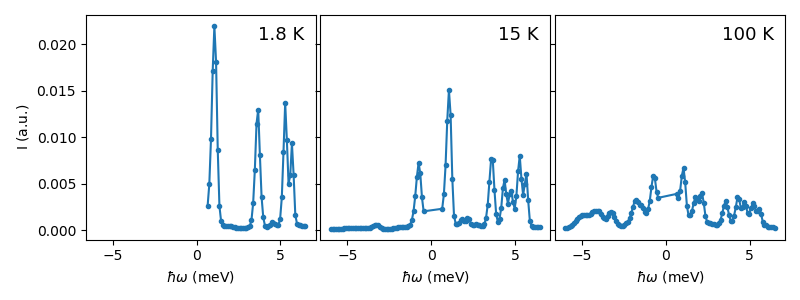

In [5]:
## Black out the elastic line, because it includes extra contributions from incoherent scattering, background, etc.
from copy import deepcopy

fitdata = deepcopy(alldata)

# fitdata[0][:,:100] *= np.nan
for i in range(len(fitdata)):
    fitdata[i] = np.hstack((fitdata[i][:,40:96], fitdata[i][:,106:-15]))
    
fitdata[0] = fitdata[0][:,56:]
    
f, ax = plt.subplots(1,3, figsize=(8,3), sharex=True, sharey=True)
for i,data in enumerate(fitdata):
    ax[i].errorbar(data[0], data[1], data[2], marker='.')
    ax[i].text(0.95,0.95, str(datatemps[i])+' K', transform=ax[i].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    ax[i].set_xlabel('$\\hbar \\omega$ (meV)')
ax[0].set_ylabel('$\\rm I$ (a.u.)')
    
plt.tight_layout()
f.subplots_adjust(wspace=0.02)

## Define global Chi2

In [6]:
# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ion = 'Er3+'
ionJ = cef.Jion[ion][2]


# Take final ligand values from above
Coefficients = np.array([-4.02401422e-02, -3.77639706e-04,  1.42541502e-02,  3.17197840e-06,
        2.22389952e-06,  3.80096353e-05])

Er_O = []
for n in range(2,8,2):
    for m in range(0,n+1,3):
        if   n == 6: i = 8 + m
        elif n == 4: i = 3 + m
        elif n == 2: i = m
        Er_O.append(  cef.StevensOp(ionJ,n,m)  )

        
Er = cef.CFLevels(Er_O, Coefficients)
Er.diagonalize()

######################

xoffset = ObsEnergies[0]+0.02
ObservedEnergies = [0]+ObsEnergies[1:]+[np.nan,np.nan, np.nan]

def err_global_final(CFLevelsObject, coeff, gammas, xoff, pref, bkg, thermexp):
    """Global error to all functions passed to it, used for fitting"""
    # define new Hamiltonian
    newH = np.sum([a*b for a,b in zip(CFLevelsObject.O, coeff)], axis=0)
    CFLevelsObject.diagonalize(newH)

    erro = 0

    # Compute error in neutron spectrum
    for i,data in enumerate(fitdata):
        errspec = (pref* CFLevelsObject.normalizedNeutronSpectrum(Earray=data[0]*(1+datatemps[i]*thermexp)-xoff,
                                                                  Temp=datatemps[i],
                                    ResFunc= lambda de: straightline(de, *width_popt), gamma=gammas[i]) )+\
                        bkg[i] -data[1]
                
        erro += np.nansum((errspec/data[2])**2)


    sys.stdout.write("\r err = "+str(erro)+'    ')
    sys.stdout.flush() # important for printing progress
    return erro

# Compare the different best fit coefficients

In [7]:
initialbkg = [0.0001, 0.0001, 0.0002]
initialthermexp = 1e-4

## These starting 'coeff' parameters are taken from CES_CEF_FitPC.ipynb; 
##     everything else is from KES_CEF_FitPC.ipynb
FitCoefRes1a={'coeff': np.array([-3.60740328e-02, -3.82694983e-04, -1.38959810e-02,  3.15219896e-06,
       -4.36048862e-06,  3.36282008e-05]), 'pref': np.array([0.00054856]), 
              'gammas': np.array([0.06884367, 0.07168863, 0.16511265]), 'xoff': np.array([0.14361942])} 

## These starting parameters are taken from KES_CEF_FitPC.ipynb
FitCoefRes2a={'coeff': np.array([ 2.32575380e-02, -4.73413709e-04,  1.26946732e-02,  1.08102667e-06,
        4.47713362e-05,  2.23404722e-05]), 'pref': np.array([0.00054856]), 
              'gammas': np.array([0.06884367, 0.07168863, 0.16511265]), 'xoff': np.array([0.14361942])} 

## Fit each set of coefficients to refine the final $\chi^2$

In [9]:
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes1aa = Er.fitdata(chisqfunc = err_global_final,  
                          fitargs = ['coeff','pref'], 
                         method = 'Nelder-Mead',
                        coeff = FitCoefRes1a['coeff'], gammas=FitCoefRes1a['gammas'], 
                        pref=FitCoefRes1a['pref'], xoff = FitCoefRes1a['xoff'], bkg=initialbkg, 
                          thermexp=initialthermexp)
##############################################################################################

 err = 19667.55416287067     19667.55416287067
 err = 837217.1876733223    837217.1876733223
Initial err = 837217.1876733223 	Final err = 19667.55416287067


In [10]:
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##############################################################################################
FitCoefRes1b = Er.fitdata(chisqfunc = err_global_final,  
                          fitargs = ['coeff','pref','gammas','xoff','bkg','thermexp'], 
                         method = 'Nelder-Mead',
                        coeff = FitCoefRes1aa['coeff'], gammas=FitCoefRes1a['gammas'], 
                        pref=FitCoefRes1aa['pref'], xoff = FitCoefRes1a['xoff'], bkg=initialbkg, 
                          thermexp=initialthermexp)
##############################################################################################

##############################################################################################
FitCoefRes2b = Er.fitdata(chisqfunc = err_global_final,  
                          fitargs = ['coeff','pref','gammas','xoff','bkg','thermexp'], 
                         method = 'Nelder-Mead',
                        coeff = FitCoefRes2a['coeff'], gammas=FitCoefRes2a['gammas'], 
                        pref=FitCoefRes2a['pref'], xoff = FitCoefRes2a['xoff'], bkg=initialbkg,
                         thermexp=initialthermexp)
##############################################################################################


# reduce the chi2
FCR = [FitCoefRes1b, FitCoefRes2b]
for fcr in FCR:
    freeparams = len(np.hstack([fcr[key] for key in fcr]))
    fcr['Chisq'] /= len(np.hstack(([alldata[i][0] for i in range(len(alldata))]))) - freeparams


print(FitCoefRes1b, FitCoefRes2b)

 err = 16710.614721427504    16710.614721427504
 err = 19667.55416287067    19667.55416287067
Initial err = 19667.55416287067 	Final err = 16710.614721427504
 err = 15564.451864266633    15564.451864266633
 err = 20221.09955892055    20221.09955892055
Initial err = 20221.09955892055 	Final err = 15564.451864266633
{'coeff': array([-2.76006429e-02, -3.98885263e-04, -1.41582191e-02,  3.15134583e-06,
       -7.68744759e-06,  3.26836317e-05]), 'pref': array([0.00053797]), 'gammas': array([0.06229384, 0.06917066, 0.13444441]), 'xoff': array([0.14515847]), 'bkg': array([0.00015433, 0.00010563, 0.00028283]), 'thermexp': array([0.00021714]), 'Chisq': 31.890486109594473} {'coeff': array([ 2.47378884e-02, -4.78169984e-04,  1.27514677e-02,  1.05507246e-06,
        4.57575724e-05,  2.19821260e-05]), 'pref': array([0.00053057]), 'gammas': array([0.06008026, 0.06785686, 0.11013868]), 'xoff': array([0.14593798]), 'bkg': array([0.00016875, 0.00011696, 0.00033504]), 'thermexp': array([0.00020307]), 'Ch

In [11]:
np.save('KES_bestfitcoeff',[FitCoefRes1b, FitCoefRes2b])

In [12]:
print(FitCoefRes1b, '\n')
print(FitCoefRes2b, '\n')
# print(FitCoefRes3a, '\n')


ErCoefFit1 = cef.CFLevels(Er_O, FitCoefRes1b['coeff'])
ErCoefFit1.diagonalize()
ErCoefFit2 = cef.CFLevels(Er_O, FitCoefRes2b['coeff'])
ErCoefFit2.diagonalize()
# ErCoefFit3 = cef.CFLevels(Er_O, FitCoefRes3a['coeff'])
# ErCoefFit3.diagonalize()

print(ErCoefFit1.gtensor(), '\n')
print(ErCoefFit2.gtensor(), '\n')
# print(ErCoefFit3.gtensor(), '\n')

{'coeff': array([-2.76006429e-02, -3.98885263e-04, -1.41582191e-02,  3.15134583e-06,
       -7.68744759e-06,  3.26836317e-05]), 'pref': array([0.00053797]), 'gammas': array([0.06229384, 0.06917066, 0.13444441]), 'xoff': array([0.14515847]), 'bkg': array([0.00015433, 0.00010563, 0.00028283]), 'thermexp': array([0.00021714]), 'Chisq': 31.890486109594473} 

{'coeff': array([ 2.47378884e-02, -4.78169984e-04,  1.27514677e-02,  1.05507246e-06,
        4.57575724e-05,  2.19821260e-05]), 'pref': array([0.00053057]), 'gammas': array([0.06008026, 0.06785686, 0.11013868]), 'xoff': array([0.14593798]), 'bkg': array([0.00016875, 0.00011696, 0.00033504]), 'thermexp': array([0.00020307]), 'Chisq': 29.703152412722584} 

[[-5.97974766  0.          0.        ]
 [ 0.         -5.97974767  0.        ]
 [ 0.          0.          4.87122471]] 

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.81725084  0.          9.55545221]] 



<IPython.core.display.Javascript object>


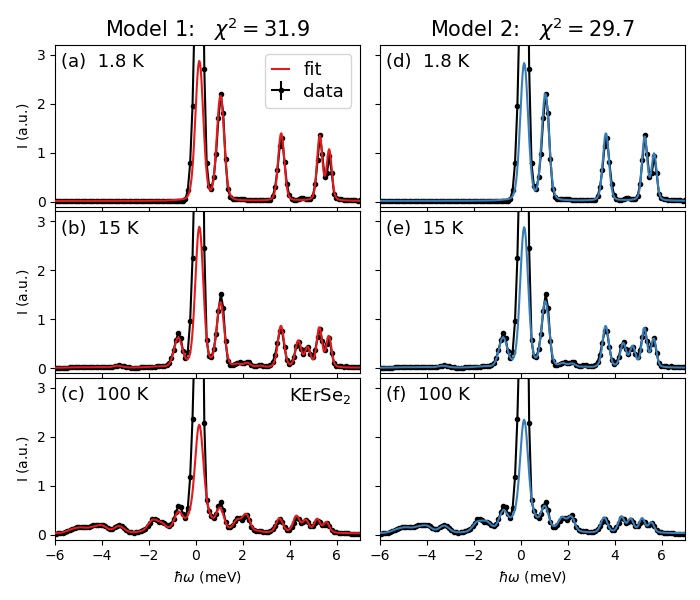

In [18]:
xxx = np.linspace(-10,30,1200)

sf = 1e2
fig2, ax = plt.subplots(3,2, figsize=(7,6), sharex=True, sharey=True)
for i,data in enumerate(alldata):
    for j in range(2):
        ax[i,j].errorbar(data[0], data[1]*sf, data[2]*sf, marker='.', label='data', color='k')
        ax[-1,j].set_xlim(-6,7)
        ax[-1,j].set_xlabel('$\\hbar \\omega$ (meV)')
    ax[i,0].set_ylabel('$\\rm I$ (a.u.)')

    ax[i,0].plot(xxx, sf*(FitCoefRes1b['pref']*ErCoefFit1.normalizedNeutronSpectrum(
                                    Earray=xxx*(1+datatemps[i]*FitCoefRes1b['thermexp'])-FitCoefRes1b['xoff'], 
                                    Temp=datatemps[i],
                                    ResFunc=lambda de: straightline(de,*width_popt),  
                                    gamma=FitCoefRes1b['gammas'][i]) + FitCoefRes1b['bkg'][i]),
              zorder=10, label='fit', color=cpal1[0])
    
    ax[i,1].plot(xxx, sf*(FitCoefRes2b['pref']*ErCoefFit2.normalizedNeutronSpectrum(
                                    Earray=xxx*(1+datatemps[i]*FitCoefRes1b['thermexp'])-FitCoefRes2b['xoff'], 
                                    Temp=datatemps[i],
                                    ResFunc=lambda de: straightline(de,*width_popt),  
                                    gamma=FitCoefRes2b['gammas'][i]) + FitCoefRes2b['bkg'][i]),
               zorder=10, color=cpal1[1])

    ax[i,0].set_ylim(-0.1,3.2)
    
for i in range(2):
    ax[0,i].set_title('Model '+str(i+1)+':   $\chi^2='+str(np.around(FCR[i]['Chisq'],1))+'$',
                     fontsize=15)

    
ax[0,0].legend(loc=1, fontsize=13, handlelength=0.9, labelspacing=0.2)


    
subplotlabels = 'abcdefghijk'
for i, axx in enumerate(ax.T.flatten()):
    axx.text(0.02,0.95, '('+subplotlabels[i]+')  '+str(datatemps[i%3])+' K', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left', fontsize=13)
    
ax[-1,0].text(0.97,0.95, '$\\rm KErSe_2$', transform=ax[-1,0].transAxes,
              verticalalignment='top', horizontalalignment='right', fontsize=13)
    
plt.tight_layout()
fig2.subplots_adjust(hspace=0.03)

In [19]:
# Compute Magnetization
ion = 'Er3+'

temp = 0.5
fieldstrengths = np.hstack((np.arange(0,0.7,0.05), np.arange(0.7,7.1,0.1)))
magnetization1 = np.zeros((len(fieldstrengths), 3, 3))
magnetization2 = np.zeros((len(fieldstrengths), 3, 3))

for i, fs in enumerate(fieldstrengths):
    magnetization1[i,0] = ErCoefFit1.magnetization(ion, temp, [fs,0,0])
    magnetization1[i,1] = ErCoefFit1.magnetization(ion, temp, [0,fs,0])
    magnetization1[i,2] = ErCoefFit1.magnetization(ion, temp, [0,0,fs])
    
    magnetization2[i,0] = ErCoefFit2.magnetization(ion, temp, [fs,0,0])
    magnetization2[i,1] = ErCoefFit2.magnetization(ion, temp, [0,fs,0])
    magnetization2[i,2] = ErCoefFit2.magnetization(ion, temp, [0,0,fs])
    
    
### Import magnetization

MHdata = np.genfromtxt('KErSe2_bulkdata/mh.dat', 
                       delimiter='\t', unpack=True, skip_header=1)

<IPython.core.display.Javascript object>


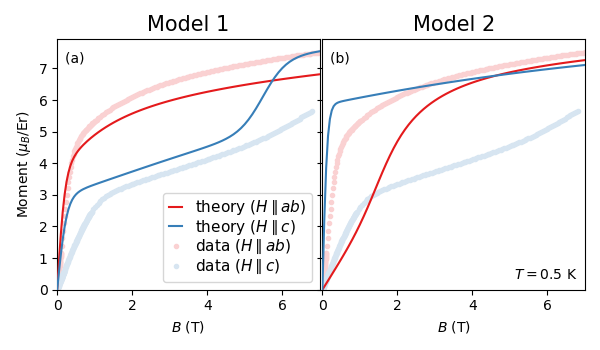

In [25]:
f, ax = plt.subplots(1,2, figsize=(6,3.5), sharex=True, sharey=True)

c_color = cpal1[1]
ab_color = cpal1[0]
abc_colors = [ab_color,ab_color,c_color]
#abc_colors_th = [pf.cpalpaired[1], pf.cpalpaired[1], pf.cpalpaired[5]]
thlabels = ['theory ($H \\parallel ab$)', 'theory ($H \\parallel ab$)', 'theory ($H \\parallel c$)']

for i in [0,2]:
    ax[0].plot(fieldstrengths, -magnetization1[:,i,i], color=abc_colors[i], zorder=10, label=thlabels[i])
    ax[1].plot(fieldstrengths, -magnetization2[:,i,i], color=abc_colors[i], zorder=10)

ax[0].set_ylabel('Moment ($\mu_B$/Er)')
ax[0].set_xlim(0,7)
ax[0].set_ylim(0,)


ax[-1].text(0.97,0.03,'$T=0.5$ K', transform=ax[-1].transAxes, 
            verticalalignment='bottom',horizontalalignment='right')

subplotlabels='abcdefg'
for i,axx in enumerate(ax):
    axx.plot(MHdata[2]/1e4,MHdata[3],  marker='.', color= 0.2*abc_colors[0] + 0.8*np.array([1,1,1,1]),
            label='data ($H \\parallel ab$)', ls='none')
    axx.plot(MHdata[22]/1e4,MHdata[23],marker='.', color= 0.2*abc_colors[2] + 0.8*np.array([1,1,1,1]),
             label='data ($H \\parallel c$)', ls='none')
    axx.set_title('Model '+str(i+1),  fontsize=15)
    axx.set_xlabel('$B$ (T)')
    axx.text(0.03,0.95, '('+subplotlabels[i]+')  ', transform=axx.transAxes,
              verticalalignment='top', horizontalalignment='left')
    
ax[0].legend(handlelength=0.9, fontsize=11, labelspacing=0.1)
plt.tight_layout()
f.subplots_adjust(wspace=0.01)


# Conclusions:
- CEF fits are underdetermined: two models fit the data almost equivalently, but give wildly different anisotropies at low temperature.
- Bulk magnetization matches model 1 much better than Model 2